<a href="https://colab.research.google.com/github/rajas2716/test/blob/main/comparisionModelPlantDisease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **1. Plant Disease Detection**

This dataset is recreated using offline augmentation from the original dataset. The original dataset can be found on [this github repo](https://github.com/spMohanty/PlantVillage-Dataset/tree/master/raw). This dataset consists of about 76K rgb images of healthy and diseased crop leaves which is categorized into 33 different classes. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10579516724036064964
 xla_global_id: -1]

In [ ]:
#Adding DataBase to drive
%pwd
!cp -r /content/drive/MyDrive/Dataset /content

#### **1.1. Import Required Libraries**



In [ ]:
import os 
import cv2
import glob
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers import Dense
from keras.models import Sequential
import keras.utils as image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from keras.layers import Convolution2D,Dense,MaxPool2D,Activation,Dropout,Flatten
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D

#### **1.2. Test-Train Data**
**Split the dataset**

**os.walk()-->**This function gives the possibility to list the contents of a directory. For example, it is used to find out which files and subdirectories are in the current directory.

In [ ]:
def get_files(directory):
  if not os.path.exists(directory):
    return 0
  count=0
  # crawls inside folders
  for current_path,dirs,files in os.walk(directory):
    for dr in dirs:
      count+= len(glob.glob(os.path.join(current_path,dr+"/*")))
  return count
train_dir ="/content/Dataset/Train "
test_dir="/content/Dataset/Test"

**glob.glob()-->**It is a module that helps to list files in a specific folder in Python. Searches in subfolders.

In [ ]:
 #train file image count
train_samples =get_files(train_dir)
#to get tags
num_classes=len(glob.glob(train_dir+"/*")) 
#test file image count
test_samples=get_files(test_dir)
print(num_classes,"Classes")
print(train_samples,"Train images")
print(test_samples,"Test images")

25 Classes
24184 Train images
6052 Test images


#### **1.3. ImageDataGenerator**

**ImageDataGenerator**,Data augmentation is used to increase the size of training set and to get more different image. Through Data augmentation we can prevent overfitting ,this refers to randomly changing the images in ways that shouldn’t impact their interpretation, such as horizontal flipping, zooming, and rotating
* **Rescale:** One of the many magnification parameters adjusts the pixel values of our image.
* **Shear_range:** counterclockwise shear angle in degrees
* **Zoom_range:** zoom
* **Horizontal_flip:** flip image horizontally

> Do not perform augmentation on validation and test data/validation set ,this might mislead the results


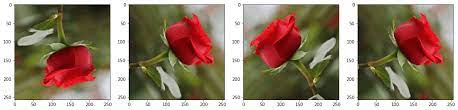

In [ ]:
train_datagen=ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
    )
test_datagen=ImageDataGenerator(rescale=1./255)

**flow_from_directory() -->** Another method to read images into TensorFlow environment is to use the .flow_from_directory() method. flow_from_directory is an ImageDataGenerator method. The dataset is read with flow_from_directory without making any changes.

**Parameters:**
* **directory:** The path of the target directory. It must contain one subdirectory per class. Any PNG, JPG, BMP, PPM or TIF formatted images found in each of the subdirectories will be included in the generator.
* **target_size:** A tuple of integers, (height, width), by default (256,256). All found images will be resized.
* **batch_size:** The size of the data chunks (default: 32).
* **shuffle:** Decides whether to shuffle data (default: True). If set to false, it sorts the data in alphanumeric order.



In [ ]:
input_shape=(224,224,3)
train_generator =train_datagen.flow_from_directory(train_dir,target_size=(224,224),batch_size=32)
test_generator=test_datagen.flow_from_directory(test_dir,shuffle=True,target_size=(224,224),batch_size=32)

Found 24184 images belonging to 25 classes.
Found 6052 images belonging to 25 classes.


#### **1.4. CNN Model**

A Convolutional Neural Network (ConvNet/CNN) is a Deep Learning algorithm which can take in an input image, assign importance (learnable weights and biases) to various aspects/objects in the image and be able to differentiate one from the other. The pre-processing required in a ConvNet is much lower as compared to other classification algorithms. While in primitive methods filters are hand-engineered, with enough training, ConvNets have the ability to learn these filters/characteristics.

In [ ]:
model = Sequential()
model.add(Conv2D(32, (5, 5),input_shape=input_shape,activation='relu',name="conv2d_1"))
model.add(MaxPooling2D(pool_size=(3, 3),name="max_pooling2d_1"))
model.add(Conv2D(32, (3, 3),activation='relu',name="conv2d_2"))
model.add(MaxPooling2D(pool_size=(2, 2),name="max_pooling2d_2"))
model.add(Conv2D(64, (3, 3),activation='relu',name="conv2d_3"))
model.add(MaxPooling2D(pool_size=(2, 2),name="max_pooling2d_3"))   
model.add(Flatten(name="flatten_1"))
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128,activation='relu'))          
model.add(Dense(num_classes,activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 220, 220, 32)      2432      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 73, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 35, 35, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 33, 33, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 64)       0

In [ ]:
validation_generator = train_datagen.flow_from_directory(
                       test_dir,
                       target_size=(224, 224),
                       batch_size=32)

Found 6052 images belonging to 25 classes.


When compiling the model, we provide **objective function (loss)**, **optimization method (adam)** and **accuracy** that we will follow.

For training, the 'fit()' function is used in the model with the following parameter:
* **train:** training data,
* **validation_data:** validation set,
* **shuffle:** change of location of data in each epoch,
* **verbose:** to be able to see the outputs during the training (0-> does not show, 1-> does)
* **epoch:** determines how many times the dataset will be trained by traversing the model
* **callbacks:** An object that can perform actions at various stages of training (for example, at the beginning or end of a period, before or after a single batch, etc.).

**ReduceLROnPlateau():** Models benefit from reducing the learning rate by 2-10 times when learning becomes sluggish. If it checks and no improvement is seen for the 'patience' count, the learning rate drops.
* **monitor**: value to monitor
* **factor:** factor by which the learning rate will be reduced
* **patience**: the number of non-development periods after which the learning rate will decrease
* **min_lr:** lower limit of learning rate


In [ ]:

Epoch = 2 #@param {type:"number"}
Patience =3 #@param {type:"number"}

In [ ]:
model.compile(optimizer='adam',loss = 'categorical_crossentropy',metrics=['accuracy'])
history1 = model.fit(
    train_generator,
    steps_per_epoch=None,
    epochs=Epoch,
    validation_data=validation_generator,
    validation_steps=None,
    verbose=1,
    callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=Patience, min_lr=0.000001)],
    shuffle=True
    )

Epoch 1/2
756/756 [==============================] - 330s 425ms/step - loss: 1.2356 - accuracy: 0.6349 - val_loss: 0.7714 - val_accuracy: 0.7482 - lr: 0.0010
Epoch 2/2
756/756 [==============================] - 322s 425ms/step - loss: 0.5463 - accuracy: 0.8231 - val_loss: 0.3807 - val_accuracy: 0.8718 - lr: 0.0010


In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/Model/plant_disease_Cnn.h5')

#### **1.5. VGG16 Model**


**VGG16** Architecture consists of 16 layers.

* **include_top :** Whether to include 3 layers fully connected to the top of the network
* **weight:** checkpoint from which model is initialized

In [ ]:
def create_Base_model_from_VGG16():  
    model = VGG16(
        weights = "imagenet",
        include_top=False, 
        input_shape = (224,224, 3)
        ) 
    for layer in model.layers:
      layer.trainable = False
    return model 
create_Base_model_from_VGG16().summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
def add_custom_layers():
    model = create_Base_model_from_VGG16()
    x = model.output
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    predictions = tf.keras.layers.Dense(num_classes, activation="softmax")(x)   
    # creating the final model 
    final_model = tf.keras.models.Model(
        inputs = model.input, 
        outputs = predictions)
     
    final_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  
    return final_model

add_custom_layers().summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
validation_generator = train_datagen.flow_from_directory(
                       test_dir, # same directory as training data
                       target_size=(224, 224),
                       batch_size=32)

Found 6052 images belonging to 25 classes.


In [ ]:
Epoch=5 #@param {type:"number"}


In [ ]:
model_from_vgg16 = add_custom_layers()
history2 = model_from_vgg16.fit(
    train_generator,
    steps_per_epoch=None,
    epochs=Epoch,
    validation_data=validation_generator,
    validation_steps=None,
    verbose=1,
    callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=3, min_lr=0.000001)],
    use_multiprocessing=False,
    shuffle=True
    )

Epoch 1/5
756/756 [==============================] - 360s 472ms/step - loss: 0.4112 - accuracy: 0.8757 - val_loss: 0.2108 - val_accuracy: 0.9316 - lr: 0.0010
Epoch 2/5
756/756 [==============================] - 355s 469ms/step - loss: 0.1740 - accuracy: 0.9428 - val_loss: 0.1855 - val_accuracy: 0.9367 - lr: 0.0010
Epoch 3/5
756/756 [==============================] - 353s 467ms/step - loss: 0.1433 - accuracy: 0.9507 - val_loss: 0.1851 - val_accuracy: 0.9400 - lr: 0.0010
Epoch 4/5
756/756 [==============================] - 352s 465ms/step - loss: 0.1120 - accuracy: 0.9597 - val_loss: 0.1357 - val_accuracy: 0.9537 - lr: 0.0010
Epoch 5/5
756/756 [==============================] - 357s 472ms/step - loss: 0.1146 - accuracy: 0.9609 - val_loss: 0.2647 - val_accuracy: 0.9237 - lr: 0.0010


In [ ]:
model_from_vgg16.save('/content/drive/MyDrive/Colab Notebooks/Model/model_VGG16.h5')

#### **1.6. VGG19 Model**

In [ ]:
def create_Base_model_from_VGG19():  
    model_vgg19 = VGG19(
        weights = "imagenet",# control point from which model is started
        include_top=False, # to include/exclude the first 3 layers
        input_shape = (224,224, 3)) # image size
    # don't train existing weights 
    for layer in model_vgg19.layers:
      layer.trainable = False
    return model_vgg19 
create_Base_model_from_VGG19().summary()

80134624/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
def add_custom_layers_vgg19():
    #Adding custom Layers 
    model_vgg19 = create_Base_model_from_VGG19()
    x = model_vgg19.output
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    predictions = tf.keras.layers.Dense(num_classes, activation="softmax")(x)   
    # creating the final model 
    final_model = tf.keras.models.Model(
        inputs = model_vgg19.input, 
        outputs = predictions)
     
    final_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  
    return final_model

add_custom_layers_vgg19().summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
validation_generator = train_datagen.flow_from_directory(
                       test_dir,
                       target_size=(224, 224),
                       batch_size=32)

Found 6052 images belonging to 25 classes.


In [ ]:
model_from_vgg19 = add_custom_layers_vgg19()
history3 = model_from_vgg19.fit(train_generator,
                      steps_per_epoch=None,
                      epochs=2,
                      validation_data=validation_generator,
                      validation_steps=None,
                      verbose=1,
                      callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=3, min_lr=0.000001)],
                      use_multiprocessing=False,
                      shuffle=True)

Epoch 1/2
756/756 [==============================] - 369s 487ms/step - loss: 0.5602 - accuracy: 0.8390 - val_loss: 0.3121 - val_accuracy: 0.8933 - lr: 0.0010
Epoch 2/2
756/756 [==============================] - 367s 485ms/step - loss: 0.2121 - accuracy: 0.9282 - val_loss: 0.2866 - val_accuracy: 0.9095 - lr: 0.0010


In [ ]:
model_from_vgg19.save('/content/drive/MyDrive/Colab Notebooks/Model/plant_disease_VGG19.h5')

#### **1.7. InceptionV3 Model**

The model will be downloaded automatically the first time the command is run to create the model. Assigning the weight parameter to the imagenet will enable the weights of the imagenet model to be used. If we want to train something using the Inception mesh, the weight parameter can be set to None, that way the weights will be randomly generated with default values.

In [ ]:
IMAGE_SIZE = [224, 224]
inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
# We don't need to train existing weights
for layer in inception.layers:
    layer.trainable = False

In [ ]:
# Model layers -> can add more if required
x = Flatten()(inception.output)
prediction = Dense(num_classes, activation='softmax')(x)
# Create a model object
model = Model(inputs=inception.input, outputs=prediction)
# View the structure of the model
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 111, 111, 32  864         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 111, 111, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                           

In [ ]:
validation_generator = train_datagen.flow_from_directory(
                       test_dir,
                       target_size=(224, 224),
                       batch_size=32)

Found 6052 images belonging to 25 classes.


In [ ]:
# Defining the cost and model optimization method to use
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
history4 = model.fit(
    train_generator,#egitim verileri
    steps_per_epoch=None,
    epochs=2,
    validation_data=validation_generator,
    validation_steps=None,
    verbose=1,
    callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=3, min_lr=0.000001)],
    shuffle=True)

Epoch 1/2
434/756 [================>.............] - ETA: 19:51 - loss: 2.5741 - accuracy: 0.7981

KeyboardInterrupt: ignored

In [ ]:
# Saving the model as a h5 file
model.save('/content/drive/MyDrive/Colab Notebooks/Model/plant_disease_inception.h5')

#### **1.8. AlexNet**

This deep convolutional neural network consisting of 25 layers consists of 5 convolution layers, 3 maxpool layers, 2 dropout layers, 3 fully connected layers, 7 relu layers, 2 normalization layers, softmax layer, input and classification (output) layers. .

In [ ]:
# Importing Keras libraries and packages
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization

In [ ]:
# Initializing the CNN
model = Sequential()
# Convolution Step 1
model.add(Convolution2D(96, 11, strides = (4, 4), padding = 'valid', input_shape=(224, 224, 3), activation = 'relu'))
# Max Pooling Step 1
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'valid'))
model.add(BatchNormalization())
# Convolution Step 2
model.add(Convolution2D(256, 11, strides = (1, 1), padding='valid', activation = 'relu'))
# Max Pooling Step 2
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding='valid'))
model.add(BatchNormalization())
# Convolution Step 3
model.add(Convolution2D(384, 3, strides = (1, 1), padding='valid', activation = 'relu'))
model.add(BatchNormalization())
# Convolution Step 4
model.add(Convolution2D(384, 3, strides = (1, 1), padding='valid', activation = 'relu'))
model.add(BatchNormalization())
# Convolution Step 5
model.add(Convolution2D(256, 3, strides=(1,1), padding='valid', activation = 'relu'))
# Max Pooling Step 3
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'valid'))
model.add(BatchNormalization())
# Flattening Step
model.add(Flatten())
# Full Connection Step
model.add(Dense(units = 4096, activation = 'relu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(Dense(units = 4096, activation = 'relu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(Dense(units = 1000, activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(units = num_classes, activation = 'softmax'))
model.summary()

In [ ]:
validation_generator = train_datagen.flow_from_directory(
                       test_dir,
                       target_size=(224, 224),
                       batch_size=32)

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
history = model.fit(    
    train_generator,
    steps_per_epoch=None,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=4,
    verbose=1,
    callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=3, min_lr=0.000001)],
    shuffle=True)

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/MyModels/model__Alexnet.h5')

In [ ]:
print("[INFO] Calculating model accuracy")
scores = model_alexnet.evaluate(validation_generator)
print(f"Test Accuracy: {scores[1]*100}")

In [ ]:
results = model_alexnet.evaluate(test_generator, verbose=1)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

In [ ]:
# Predict the label of the test_gen
pred = model.predict(test_generator,verbose=1)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

In [ ]:
y_test = list(train_generator.Label)
print(classification_report(y_test, pred))

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
import numpy

print(history5.history.keys())

plt.plot(history5.history['accuracy'])
plt.plot(history5.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### **1.9. ResNet50 Model**

In [ ]:
pretrained_model = ResNet50(
    input_shape=(224,224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

In [ ]:
inputs = pretrained_model.input

x = Dense(128, activation='relu')(pretrained_model.output)
x = Dense(128, activation='relu')(x)

outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
my_callbacks  = [EarlyStopping(monitor='val_loss',min_delta=0,patience=3,mode='auto')]

In [ ]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=my_callbacks,
    verbose=1,
    steps_per_epoch=None,
    validation_steps=4
)

Epoch 1/10
732/732 [==============================] - 4790s 6s/step - loss: 2.5291 - accuracy: 0.1877 - val_loss: 2.0778 - val_accuracy: 0.2969
Epoch 2/10
732/732 [==============================] - 193s 264ms/step - loss: 1.9484 - accuracy: 0.3643 - val_loss: 1.8482 - val_accuracy: 0.3828
Epoch 3/10
732/732 [==============================] - 191s 261ms/step - loss: 1.6594 - accuracy: 0.4600 - val_loss: 1.4655 - val_accuracy: 0.5156
Epoch 4/10
732/732 [==============================] - 192s 262ms/step - loss: 1.5006 - accuracy: 0.5085 - val_loss: 1.4322 - val_accuracy: 0.5625
Epoch 5/10
732/732 [==============================] - 189s 259ms/step - loss: 1.4102 - accuracy: 0.5387 - val_loss: 1.3795 - val_accuracy: 0.5391
Epoch 6/10
732/732 [==============================] - 184s 251ms/step - loss: 1.3287 - accuracy: 0.5653 - val_loss: 1.1696 - val_accuracy: 0.6484
Epoch 7/10
732/732 [==============================] - 187s 255ms/step - loss: 1.2879 - accuracy: 0.5774 - val_loss: 1.1611 - v

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/MyModels/model_resnet50.h5')

In [ ]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(validation_generator)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
147/147 [==============================] - 652s 4s/step - loss: 1.2280 - accuracy: 0.5949
Test Accuracy: 59.48718190193176


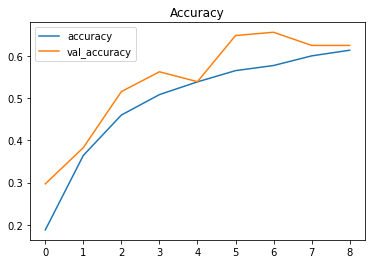

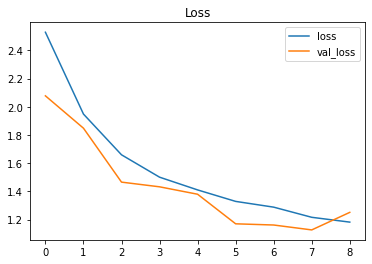

In [ ]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

### **2. Prediction From the model**

#### **2.1. CNN Model**

In [ ]:
import numpy as np
from keras.models import load_model
from keras.preprocessing import image
model_cnn=load_model('/content/drive/MyDrive/Colab Notebooks/Model/plant_disease_Cnn.h5')

1/1 [==============================] - 0s 75ms/step
Soybean___healthy


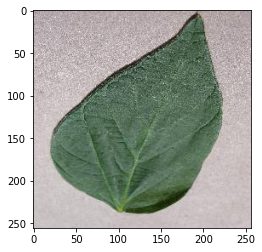

In [ ]:
classes=list(train_generator.class_indices.keys())
# Pre-Processing test data same as train data.
def prepare(img_path):
    img = keras.utils.load_img(img_path, target_size=(224,224))
    x = tf.keras.utils.img_to_array(img)
    x = x/255
    return np.expand_dims(x, axis=0)
    
img_url='/content/Dataset/Test/Soybean___healthy/077906a4-255c-4330-9fb6-e923f58ae1d4___RS_HL 3890.JPG'
result_cnn = model_cnn.predict([prepare(img_url)])
disease=keras.utils.load_img(img_url)
plt.imshow(disease)

classresult=np.argmax(result_cnn,axis=1)
print(classes[classresult[0]])

In [ ]:
tot=0
curr=0
import os
dir = '/content/Dataset/Test'
for f1 in os.scandir(dir):
  for f2 in os.listdir(f1):
    tot = tot+1
    strin = str(f1)
    img_dir = os.path.join(dir,f1,f2)
    curr_res = model_cnn.predict([prepare(img_dir)])
    disease = keras.utils.load_img(img_dir)
    plt.imshow(disease)
    classresult = np.argmax(curr_res,axis=1)
    res = strin.split("'")
    print(classes[classresult[0]],curr)
    if(classes[classresult[0]]==res[1]):
      curr=curr+1;
  
os.system('cls')
print("accuracy on test dataset = ", curr/tot*100)

#### **2.2. VGG16 Model**

In [ ]:
import numpy as np
from keras.models import load_model
from keras.preprocessing import image
model_vgg16=load_model('/content/drive/MyDrive/Colab Notebooks/Model/model_VGG16.h5')

1/1 [==============================] - 1s 1s/step
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot


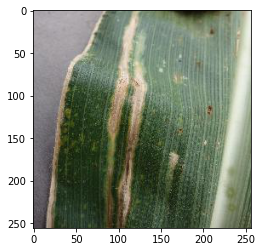

In [ ]:
classes=list(train_generator.class_indices.keys())
# Pre-Processing test data same as train data.
def prepare(img_path):
    img = keras.utils.load_img(img_path, target_size=(224,224))
    x = tf.keras.utils.img_to_array(img)
    x = x/255
    return np.expand_dims(x, axis=0)
    
img_url='/content/Dataset/Test/Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot/ce3b19bd-dace-4d23-836e-233b02f12300___RS_GLSp 4505.JPG'
result_vgg16 = model_vgg16.predict([prepare(img_url)])
disease=keras.utils.load_img(img_url)
plt.imshow(disease)

classresult=np.argmax(result_vgg16,axis=1)
print(classes[classresult[0]])

1/1 [==============================] - 1s 584ms/step
Corn_(maize)___healthy 0
1/1 [==============================] - 1s 601ms/step
Corn_(maize)___healthy 1
1/1 [==============================] - 1s 561ms/step
Corn_(maize)___healthy 2
1/1 [==============================] - 1s 647ms/step
Corn_(maize)___healthy 3
1/1 [==============================] - 1s 611ms/step
Corn_(maize)___healthy 4
1/1 [==============================] - 1s 564ms/step
Corn_(maize)___healthy 5
1/1 [==============================] - 1s 586ms/step
Corn_(maize)___healthy 6
1/1 [==============================] - 1s 571ms/step
Corn_(maize)___healthy 7
1/1 [==============================] - 1s 565ms/step
Corn_(maize)___healthy 8
1/1 [==============================] - 1s 572ms/step
Corn_(maize)___healthy 9
1/1 [==============================] - 1s 564ms/step
Peach___Bacterial_spot 10
1/1 [==============================] - 1s 571ms/step
Peach___Bacterial_spot 11
1/1 [==============================] - 1s 548ms/step
Peach___B

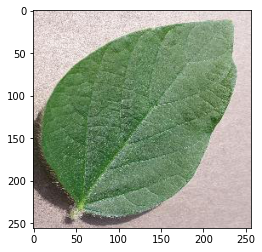

In [ ]:
tot=0
curr=0
import os
dir = '/content/Dataset/Test'
for f1 in os.scandir(dir):
  for f2 in os.listdir(f1)[:10]:
    tot = tot+1
    strin = str(f1)
    img_dir = os.path.join(dir,f1,f2)
    curr_res = model_vgg16.predict([prepare(img_dir)])
    disease = keras.utils.load_img(img_dir)
    plt.imshow(disease)
    classresult = np.argmax(curr_res,axis=1)
    res = strin.split("'")
    print(classes[classresult[0]],curr)
    if(classes[classresult[0]]==res[1]):
      curr=curr+1;
  
os.system('cls')
print("accuracy on test dataset = ", curr/tot*100)

#### **2.3. VGG19 Model**

In [ ]:
import numpy as np
from keras.models import load_model
from keras.preprocessing import image
model_vgg19=load_model('/content/drive/MyDrive/Colab Notebooks/Model/plant_disease_VGG19.h5')

Pepper_Healthy


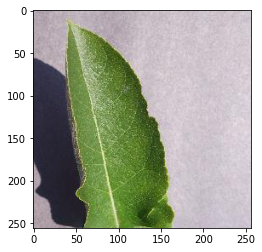

In [ ]:
classes=list(train_generator.class_indices.keys())
# Pre-Processing test data same as train data.
def prepare(img_path):
    img = image.load_img(img_path, target_size=(224,224))
    x = image.img_to_array(img)
    x = x/255
    return np.expand_dims(x, axis=0)
    
img_url='/content/drive/MyDrive/Colab Notebooks/dataset/plant__leaf/val/Apple__Healthy/78e648c6-a360-4fa8-b8ab-1225b164b7fd___RS_HL 7243.JPG'
result_vgg19 = model_vgg19.predict([prepare(img_url)])
disease=image.load_img(img_url)
plt.imshow(disease)

classresult=np.argmax(result_vgg19,axis=1)
print(classes[classresult[0]])

#### **2.4. Inception Model**

In [ ]:
import numpy as np
from keras.models import load_model
from keras.preprocessing import image
model_inception=load_model('/content/drive/MyDrive/Colab Notebooks/Model/plant_disease_inception.h5')

Apple__Healthy


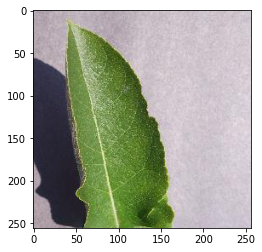

In [ ]:
classes=list(train_generator.class_indices.keys())
# Pre-Processing test data same as train data.
def prepare(img_path):
    img = image.load_img(img_path, target_size=(224,224))
    x = image.img_to_array(img)
    x = x/255
    return np.expand_dims(x, axis=0)
    
img_url='/content/drive/MyDrive/Colab Notebooks/dataset/plant__leaf/val/Apple__Healthy/78e648c6-a360-4fa8-b8ab-1225b164b7fd___RS_HL 7243.JPG'
result_inception = model_inception.predict([prepare(img_url)])
disease=image.load_img(img_url)
plt.imshow(disease)

classresult=np.argmax(result_inception,axis=1)
print(classes[classresult[0]])

#### **2.5. AlexNet Model**

In [ ]:
import numpy as np
from keras.models import load_model
from keras.preprocessing import image
model_alexnet=load_model('/content/drive/MyDrive/Colab Notebooks/Model/plant_disease_alexnet2.h5')

Pepper_Healthy


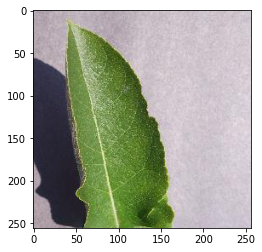

In [ ]:
classes=list(train_generator.class_indices.keys())
# Pre-Processing test data same as train data.
def prepare(img_path):
    img = image.load_img(img_path, target_size=(224,224))
    x = image.img_to_array(img)
    x = x/255
    return np.expand_dims(x, axis=0)
    
img_url='/content/drive/MyDrive/Colab Notebooks/dataset/plant__leaf/val/Apple__Healthy/78e648c6-a360-4fa8-b8ab-1225b164b7fd___RS_HL 7243.JPG'
result_alexnet = model_alexnet.predict([prepare(img_url)])
disease=image.load_img(img_url)
plt.imshow(disease)

classresult=np.argmax(result_alexnet,axis=1)
print(classes[classresult[0]])

#### **2.6. ResNet50 Model**

In [ ]:
import numpy as np
from keras.models import load_model
from keras.preprocessing import image
model_alexnet=load_model('/content/drive/MyDrive/Colab Notebooks/Model/plant_disease_alexnet2.h5')

Pepper_Healthy


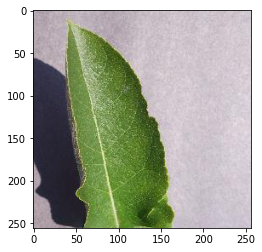

In [ ]:
classes=list(train_generator.class_indices.keys())
# Pre-Processing test data same as train data.
def prepare(img_path):
    img = image.load_img(img_path, target_size=(224,224))
    x = image.img_to_array(img)
    x = x/255
    return np.expand_dims(x, axis=0)
    
img_url='/content/drive/MyDrive/Colab Notebooks/dataset/plant__leaf/val/Apple__Healthy/78e648c6-a360-4fa8-b8ab-1225b164b7fd___RS_HL 7243.JPG'
result_alexnet = model_alexnet.predict([prepare(img_url)])
disease=image.load_img(img_url)
plt.imshow(disease)

classresult=np.argmax(result_alexnet,axis=1)
print(classes[classresult[0]])